In [20]:
import numpy as np
import pandas as pd
from new_SPOC import *
import old_SPOC as old_SPOC
from generate_SPOC_model import *
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output, display

%matplotlib inline

In [2]:
n_nodes = 1000
n_clusters = 3
n_repetitions = 10
pn_number = n_clusters

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "eps",\
                                 "seed", "method", "matrix", "error"])

for eps in np.arange(0.05, 0.5, 0.05):
    B = np.diag([0.5-eps, 0.5, 0.5+eps])
    B = B / np.max(B)
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        
        err, _ = find_permutation_Theta(Theta, theta_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"Geo_NMF", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"Geo_NMF", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_spa, b_spa = SPOC(A, n_clusters)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"basic_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"basic_SPA", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_bootstrap, b_bootstrap = SPOC_bootstrap(A, n_clusters, n_repetitions=300, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"bootstrap_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "eps":eps, "seed":repeat, "method":"bootstrap_SPA", "matrix":"B", "error":err}, ignore_index=True)

EXP_DATA.to_csv("skewness.csv", index=None)

IOError: 'presentation' not found in the style library and input is not a valid URL or path. See `style.available` for list of available styles.

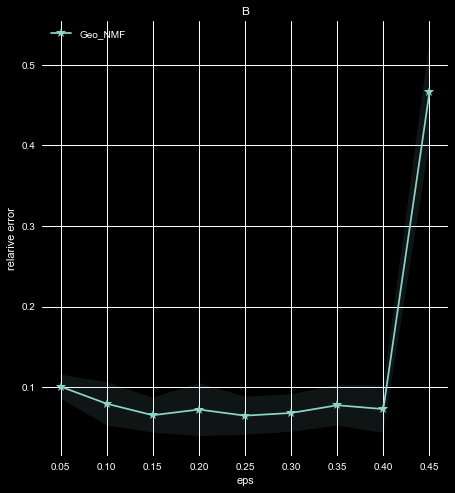

In [33]:
EXP_DATA = pd.read_csv("skewness.csv")

df = EXP_DATA.groupby(["eps",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["eps",  "method", "matrix"]).error.std().reset_index()

fig = plt.figure(figsize=(16,8))

for method in df.method.unique():
    
    if method == "basic_SPA":
        continue
    
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.eps, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.eps, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("eps")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.legend(loc="upper left")
        plt.style.use('presentation')
        matplotlib.rcParams.update({'font.size': 40})
        plt.grid()
        #plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("skewness.png")